In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import drjit as dr
import mitsuba as mi
from matplotlib import pyplot as plt
from mitsuba.scalar_rgb import Transform4f as T
import torch
import numpy as np

import time
from utils_optim import run_optimization, run_grad_optimization, run_cg_optimization, run_bfgs_optimization
from utils_general import run_scheduler_step, show_with_error, plt_errors
from read_scenes import setup_coffecup_scene
import utils_fns
from utils_mitsuba import get_mts_rendering, render_smooth
from optimizations import adam_opt, NCG_smooth, BFGS_opt, mi_opt

In [22]:
mi.set_variant('cuda_ad_rgb')
device = 'cuda'
integrator = {
    'type': 'direct_projective',
}
scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '../scenes/rabbit/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]).scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': '../scenes/rabbit/meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    'light': {
        'type': 'obj',
        'filename': '../scenes/rabbit/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
    }
})

In [23]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

def apply_transformation(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    opt['angle'] = dr.clamp(opt['angle'], -0.5, 0.5)

    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0]).rotate([0, 1, 0], opt['angle'] * 100.0)

    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

def apply_transformation_ours(theta, p, mat_id='bunny.vertex_positions', init_vpos=initial_vertex_positions):
    # if isinstance(theta, torch.Tensor):
    #     theta = theta.tolist()
    trafo = mi.Transform4f.translate([float(theta[0]), float(theta[1]), 0.0]).rotate([0, 1, 0], float(theta[2]) * 100.0)

    p[mat_id] = dr.ravel(trafo @ init_vpos)
    p.update()

# Initialize

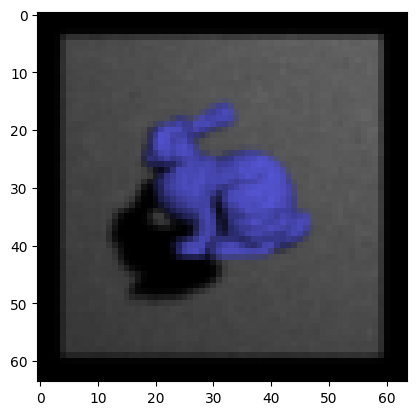

In [24]:
GT_theta = torch.tensor([0, 0, 0], dtype=torch.float32)
apply_transformation_ours(GT_theta, params)
GT_img = mi.render(scene, params, seed=0, spp=1024)
plt.imshow(GT_img)
plt.show()

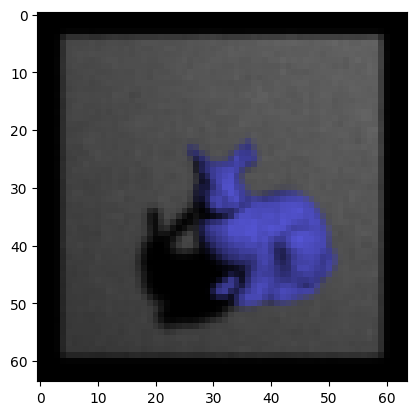

In [25]:
initial_theta = torch.tensor([0.25, -0.25, 0.25], dtype=torch.float32)
apply_transformation_ours(initial_theta, params)
initial_img = mi.render(scene, params, seed=0, spp=1024)
plt.imshow(initial_img)
plt.show()

# Mitsuba

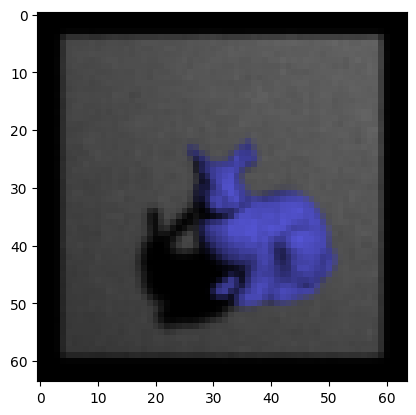

In [59]:
dr.enable_grad(params)
opt = mi.ad.Adam(lr=2e-2)
opt['angle'] = mi.Float(float(initial_theta[2]))
opt['trans'] = mi.Point2f(float(initial_theta[0]), float(initial_theta[1]))
apply_transformation(params, opt)
img_init = mi.render(scene, seed=0, spp=1024)
plt.imshow(img_init)
plt.show()

max_iter = 100
spp=32

In [60]:
img_err, param_err, iter_times = [], [], []
for it in range(max_iter):
    start_time = time.time()
    apply_transformation(params, opt)

    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)
    cur_img_loss = dr.mean((img - GT_img)**2) 
    dr.backward(cur_img_loss)
    opt.step()
    
    # img_err.append(cur_img_loss[0])
    # cur_param_loss = (opt['angle'] - mi.Float(float(GT_theta[2])))**2 + dr.sum((opt['trans'] - mi.Point2f(float(GT_theta[0]), float(GT_theta[1])))**2) /3
    # param_err.append(cur_param_loss[0])
    end_time = time.time()
    iter_time = end_time - start_time
    
    with torch.no_grad():
        img_torch = torch.tensor(img, dtype=torch.float32, device=device)
        GT_img_torch = torch.tensor(GT_img, dtype=torch.float32, device=device)
        img_err.append(torch.nn.MSELoss()(img_torch, GT_img_torch).item())
        cur_theta = torch.tensor([[opt['trans'][0], opt['trans'][1], opt['angle']]], dtype=torch.float32, device=device)
        GT_theta_gpu = GT_theta.unsqueeze(0).to(device)
        param_err.append(torch.nn.MSELoss()(cur_theta, GT_theta_gpu).item())
        iter_times.append(iter_time)
        pstring = ' - CurrentParam: {}'.format(cur_theta.tolist()) 
        print(f"Iter {it + 1}/{max_iter}, ParamLoss: {param_err[-1]:.6f}, "
                f"ImageLoss: {img_err[-1]:.8f} - Time: {iter_time:.4f}{pstring}")
    # print(f"Iteration {it:02d}: ParamLoss= {cur_param_loss[0]:.6f}, ImageLoss={cur_img_loss[0]:.8f}")
    # print(f"angle={opt['angle'][0]:.4f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]")
    

Iter 1/100, ParamLoss: 0.052901, ImageLoss: 0.00865736 - Time: 0.6766 - CurrentParam: [[[0.23000071942806244], [-0.23000113666057587], [0.23000411689281464]]]
Iter 2/100, ParamLoss: 0.045447, ImageLoss: 0.00837645 - Time: 0.6744 - CurrentParam: [[[0.2101319134235382], [-0.2119600921869278], [0.21739265322685242]]]
Iter 3/100, ParamLoss: 0.040704, ImageLoss: 0.00818514 - Time: 0.6558 - CurrentParam: [[[0.19060947000980377], [-0.208535298705101], [0.2056548148393631]]]
Iter 4/100, ParamLoss: 0.036624, ImageLoss: 0.00799043 - Time: 0.6333 - CurrentParam: [[[0.1709362119436264], [-0.20774328708648682], [0.193634033203125]]]
Iter 5/100, ParamLoss: 0.034936, ImageLoss: 0.00742872 - Time: 0.6027 - CurrentParam: [[[0.15195515751838684], [-0.21370293200016022], [0.1898665875196457]]]
Iter 6/100, ParamLoss: 0.033286, ImageLoss: 0.00739955 - Time: 0.6551 - CurrentParam: [[[0.13269789516925812], [-0.21797588467597961], [0.18637917935848236]]]
Iter 7/100, ParamLoss: 0.032387, ImageLoss: 0.00702274 

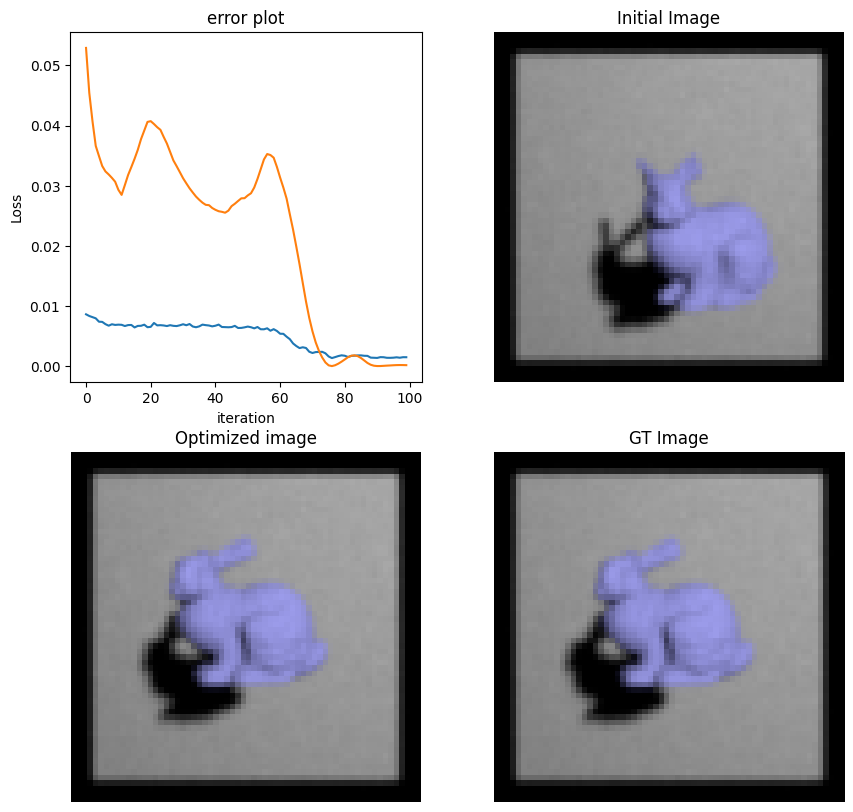

In [61]:
for j, loss_i in enumerate(param_err):
    if loss_i <= 0.00003:
        idx = j
        img_err = img_err[:idx+1]
        param_err = param_err[:idx+1]
        iter_times = iter_times[:idx+1]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(img_err, label='image error')
axs[0][0].plot(param_err, label='parameter error')
axs[0][0].set_xlabel('iteration')
axs[0][0].set_ylabel('Loss')
axs[0][0].set_title('error plot')

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(GT_img))
axs[1][1].axis('off')
axs[1][1].set_title('GT Image')
plt.show()

In [62]:
i=19
np.save(f'./results/rabbit/rabbit_mitsuba/rabbit_mitsuba_f_loss_{i}.npy', img_err)
np.save(f'./results/rabbit/rabbit_mitsuba/rabbit_mitsuba_param_loss_{i}.npy', param_err)
np.save(f'./results/rabbit/rabbit_mitsuba/rabbit_mitsuba_times_{i}.npy', iter_times)

# Plotting

(53,)
(137,) (137,)
(60,) (60,)
(27,) (27,)
(59,) (59,)
(27,) (27,)
FR22 median id: 7
FR22 median time traj: [-0.06149122  0.78860524  1.6387017   2.48879816  3.33889462  4.18899108
  5.03908753  5.88918399  6.73928045  7.58937691  8.43947337  9.28956983
 10.13966628 10.98976274 11.8398592  12.68995566 13.54005212 14.39014858
 15.24024504 16.09034149 16.94043795 17.79053441 18.64063087 19.49072733
 20.34082379 21.19092024 22.0410167  22.89111316 23.74120962 24.59130608
 25.44140254 26.291499   27.14159545 27.99169191 28.84178837 29.69188483
 30.54198129 31.39207775 32.2421742  33.09227066]
FR22 median f_loss traj: [6.98202714e-03 6.62896453e-03 5.88468786e-03 5.71798362e-03
 5.71203382e-03 5.60005169e-03 5.28743907e-03 4.61603741e-03
 3.91393367e-03 2.30052849e-03 2.55521778e-03 1.64185450e-03
 1.10517493e-03 9.70300758e-04 5.63809432e-04 4.07176450e-04
 5.24387976e-05 3.27199941e-04 9.66655672e-06 5.40085253e-04
 3.37963430e-04 2.82658788e-04 5.49356780e-04 3.02939603e-04
 4.07802887e

Text(0.5, 1.0, 'rabbit task optimization(Median of 20 random points)')

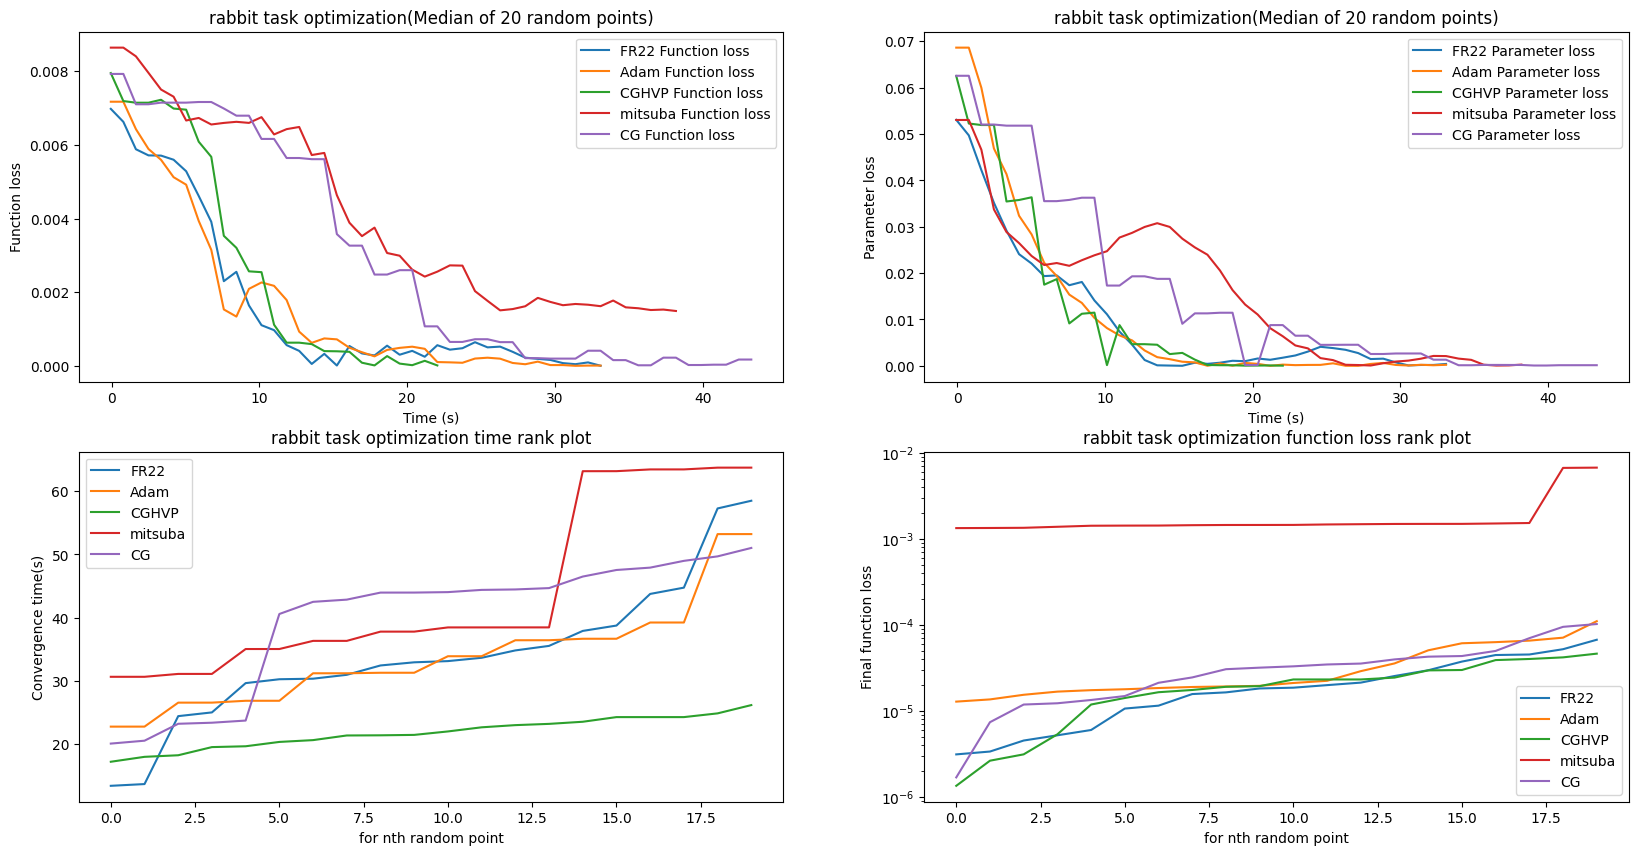

In [174]:
# np.save('potential_loss_hist.npy', loss_hist)
# np.save('potential_time_hist.npy', time_hist)
n_starting_points = 20
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
task = 'rabbit'
path = './results/' + task + '/'
opts = ['mi', 'adam', 'cg_HVP', 'mitsuba', 'cg']
opt_names = ['FR22', 'Adam', 'CGHVP', 'mitsuba', 'CG']

percentiles = [0.1, 0.01, 1e-3]

final_times = {'final_times_cg':[],
                'final_times_mi': [],
                'final_times_adam': [],
                'final_times_cg_HVP': [],
                'final_times_mitsuba': []
                }
final_conv = {'final_conv_cg':[],
            'final_conv_mi': [],
            'final_conv_adam': [],
            'final_conv_cg_HVP': [],
            'final_conv_mitsuba': []
            }

mean_final_times = np.zeros((len(opts), n_starting_points))
mean_f_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))
mean_param_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))

for i in range(n_starting_points):
    for j in range(len(opts)):
        iter_times = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_times_{i}.npy')
        f_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_f_loss_{i}.npy')
        param_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_param_loss_{i}.npy')
        times = np.cumsum(iter_times)
        
        final_times['final_times_'+opts[j]].append(times[-1])
        final_conv['final_conv_'+opts[j]].append([f_loss[-1].squeeze(), param_loss[-1].squeeze()])
        mean_final_times[j, i] = times[-1] 
        # for percentile time
        for l, percentile in enumerate(percentiles):
            initial_f_error = f_loss[0].squeeze()
            initial_param_error = param_loss[0].squeeze()
            for k, f_error in enumerate(f_loss):
                if f_error <= initial_f_error*percentile:
                    mean_f_percentile_times[j, l, i] = times[k]
                    break
            for k, param_error in enumerate(param_loss.squeeze()):
                if param_error <= initial_param_error*percentile:
                    mean_param_percentile_times[j, l, i] = times[k]
                    break
def round_to_nearest(times, new_times):
    return np.argmin(np.abs(new_times - times))

mean_final_times = mean_final_times.mean(axis=1)
mean_f_percentile_times = mean_f_percentile_times.mean(axis=2)
mean_param_percentile_times = mean_param_percentile_times.mean(axis=2)
median_datasets = []
for i in range(len(opts)):
    median_id = np.argsort(final_times['final_times_'+opts[i]])[len(final_times['final_times_'+opts[i]])//2]
    iter_times = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_times_{median_id}.npy')
    f_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_f_loss_{median_id}.npy')
    param_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_param_loss_{median_id}.npy')
    median_datasets.append({'times': np.cumsum(iter_times), 'f_loss': f_loss, 'param_loss': param_loss})
    
all_times = np.concatenate([d['times'] for d in median_datasets])
global_start, global_end = np.min(all_times), np.max(all_times)
smallest_set = min(median_datasets, key=lambda x: len(x['times']))
smallest_times = smallest_set['times']
average_iter_time = np.mean(np.diff(smallest_times))
new_timestamps = np.arange(global_start, global_end+average_iter_time, average_iter_time)
print(new_timestamps.shape)
new_median_datasets = []
for i, data in enumerate(median_datasets):
    times = data['times']
    # rounded_times = np.unique(rounded_times)
    f_loss_rounded = []
    param_loss_rounded = []
    f_loss_orig = data['f_loss']
    print(times.shape, f_loss_orig.shape)
    for j, t in enumerate(new_timestamps):
        if t > times[-1]:
            break
        nearest_idx = round_to_nearest(times, t)
        f_loss_rounded.append(f_loss_orig[nearest_idx])
        param_loss_rounded.append(data['param_loss'][nearest_idx])
    f_loss_rounded = np.array(f_loss_rounded)
    param_loss_rounded = abs(np.array(param_loss_rounded))
    new_median_datasets.append({'times': new_timestamps[:len(f_loss_rounded)], 'f_loss': f_loss_rounded, 'param_loss': param_loss_rounded})
    # new_median_datasets[[opts[j]]] = {'times': rounded_times, 'f_loss': f_loss_rounded, 'param_loss': param_loss_rounded}
    

for i in range(len(opts)):
    sorted_conv = np.sort(final_conv['final_conv_'+opts[i]], axis=0)
    sorted_time = np.sort(final_times['final_times_'+opts[i]])
    times = new_median_datasets[i]['times']
    f_loss = new_median_datasets[i]['f_loss']
    param_loss = new_median_datasets[i]['param_loss']
    label_prefix = opt_names[i]
        
    with np.printoptions(threshold=np.inf):
        print(f'{label_prefix} median id: {median_id}')
        print(f'{label_prefix} median time traj: {times}')
        print(f'{label_prefix} median f_loss traj: {f_loss}')
        print(f'{label_prefix} median param_loss traj: {param_loss}')
        print(f'{label_prefix} average time: {mean_final_times[i]}')
    for j in range(len(percentiles)):
        print(f'{label_prefix} average time for {percentiles[j]} percentile in function loss: {mean_f_percentile_times[i, j]}')
        print(f'{label_prefix} average time for {percentiles[j]} percentile in parameter loss: {mean_param_percentile_times[i, j]}')
    
    ax[0,0].plot(times, f_loss, label=label_prefix + ' Function loss')
    ax[0,1].plot(times, param_loss.squeeze(), label=label_prefix+' Parameter loss')
    print(f'{label_prefix} convergence times: {sorted_time}')
    print(f'{label_prefix} convergence function loss: {np.abs(sorted_conv[:,0])}')
    print(f'{label_prefix} convergence parameter loss: {np.abs(sorted_conv[:,1])}')
    ax[1,0].plot(sorted_time, label=label_prefix)
    ax[1,1].plot(sorted_conv[:,0], label=label_prefix)
    
ax[1,0].set_xlabel('for nth random point')
ax[1,0].set_ylabel('Convergence time(s)')
ax[1,0].set_title(f'{task} task optimization time rank plot')
ax[1,0].legend()

ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('for nth random point')
ax[1,1].set_ylabel('Final function loss')
ax[1,1].set_title(f'{task} task optimization function loss rank plot')
ax[1,1].legend()

ax[0,0].legend()
ax[0,1].legend()
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Function loss')
ax[0,0].set_title(f'{task} task optimization(Median of {n_starting_points} random points)')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Parameter loss')
ax[0,1].set_title(f'{task} task optimization(Median of {n_starting_points} random points)')
# save_path = './results/' + task + '/' + task + '_task.pdf'
# plt.savefig(save_path, format='pdf')
# ax[0,0].set_yscale('log')
# ax[0,1].set_yscale('log')
# save_path = './results/' + task + '/' + task + '_task_log.pdf'
# plt.savefig(save_path, format='pdf') 